In [92]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, Lasso, ElasticNetCV
from sklearn.model_selection import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline


def rmse_cv(model,cv=5):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = cv))
    return rmse


train = pd.read_csv("../input/train.csv",error_bad_lines=False)
train.drop(train[train["GrLivArea"]>4000].index, inplace=True)
train.drop(train[train["EnclosedPorch"]>500].index, inplace=True)
 

    
test = pd.read_csv("../input/test.csv",error_bad_lines=False)


quality_feats = ["MSZoning","OverallQual","OverallCond","Neighborhood","ExterQual", "ExterCond", "BsmtQual","BsmtCond","HeatingQC",
            "KitchenQual","FireplaceQu","GarageQual","GarageCond","BsmtExposure",
            "BsmtFinType1","BsmtFinType2", "Functional", "Fence", "GarageFinish", "PavedDrive"]
qual_dict = {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
bsmt_fin_dict = {"Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
bsmt_exposure_dict = {"No": 1, "Mn": 2, "Av": 3, "Gd": 4}
Functional_dict = {"Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, "Mod": 5,
                         "Min2": 6, "Min1": 7, "Typ": 8}
Fence_dict = {"MnWw": 1, "GdWo": 2, "MnPrv": 3, "GdPrv": 4}
GarageFinish_dict = {"Unf": 1, "RFn": 2, "Fin": 3}
pave_drive_dict = {"Y": 3, "P":2, "N": 1}
# MS Zoning (Nominal): Identifies the general zoning classification of the sale.


for feature in quality_feats:
#     dic = train["SalePrice"].groupby(train[feature]).mean().sort_values()
    dic ={}
    if feature in ["Neighborhood", "OverallQual", "OverallCond","MSZoning"]:
        dic = train["SalePrice"].groupby(train[feature]).mean().sort_values()
    elif feature is "BsmtExposure":
        dic = bsmt_exposure_dict
    elif feature is "BsmtFinType1" or feature is "BsmtFinType2":
        dic = bsmt_fin_dict
    elif feature is "Functional":
        dic = Functional_dict
    elif feature is "Fence":
        dic = Fence_dict
    elif feature is "GarageFinish":
        dic = GarageFinish_dict
    elif feature is "PavedDrive":
        dic = pave_drive_dict
    else: dic  = qual_dict
    train.insert(1, "_"+feature, train[feature].replace(dic))
    test.insert(1, "_"+feature, test[feature].replace(dic))

# print train._OverallQual

# print len(train.columns)
# print len(test.columns)
# print train.loc[:, '_ExterQual':'_BsmtFinType2','MSSubClass':'SaleCondition' ] 
# print train.loc[:,'MSSubClass':'SaleCondition']

# print train.columns
test.loc[666, "GarageQual"] = "TA"
test.loc[666, "GarageCond"] = "TA"
test.loc[666, "GarageFinish"] = "Unf"
test.loc[666, "GarageYrBlt"] = "1980"

# add columns


train.insert(1, "HouseAge", 2010 - train["YearBuilt"])
test.insert(1, "HouseAge", 2010 - test["YearBuilt"])
train.insert(1, "TimeSinceSold", 2010 - train["YrSold"])
test.insert(1, "TimeSinceSold", 2010 - test["YrSold"])
train.insert(1, "_CentralAir", train["CentralAir"]=="Y")
test.insert(1, "_CentralAir", test["CentralAir"]=="Y")




# YearBuilt, YearRemodAdd, YrSold, GarageYrBlt

all_data = pd.concat((train.loc[:,"TimeSinceSold":'SaleCondition'],
                      test.loc[:,"TimeSinceSold":'SaleCondition']))

# print all_data.columns


#     print train[feature]
#     print test[feature]
all_data["GarageYrBlt"] = pd.to_numeric(all_data["GarageYrBlt"], errors='ignore')



# feature data replacing
all_data = all_data.replace({'MoSold': {1: 'Jan', 
                                        2: 'Feb', 
                                        3: 'Mar', 
                                        4: 'Apr',
                                        5: 'May', 
                                        6: 'Jun',
                                        7: 'Jul',
                                        8: 'Avg',
                                        9: 'Sep',
                                        10: 'Oct',
                                        11: 'Nov',
                                        12: 'Dec'}})



# log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) # compute skewness
skewed_feats = skewed_feats[skewed_feats>0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

# fill not available for String "None"
all_data = all_data.fillna({'MasVnrType': 'None'})
# print all_data["MasVnrType"].unique()

all_data = pd.get_dummies(all_data)
all_data = all_data.fillna(all_data.mean())


# target value normalize
# matplotlib.rcParams['figure.figsize'] = (12., 6.)
# prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
# prices.hist()

# train.head()

# log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])


X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

print X_train.shape
print X_test.shape


print y.shape

print X_test.shape
# with pd.option_context('display.max_rows', 999, 'display.max_columns', 10000):
#     print list(X_train.columns)
#     print list(X_test.columns)
#     print X_train.describe()
#     print X_test.describe()
    
# drop missing data
# print X_test.ix[:, (X_test == 0).all()].columns

# drop_columns = X_test.columns[(X_test == 0).all()]
drop_columns = X_test.columns[(X_test.astype(bool).sum(axis=0) < 5)]

X_train.drop(drop_columns, axis=1, inplace=True)
X_test.drop(drop_columns, axis=1, inplace=True)
# with pd.option_context('display.max_rows', 999, 'display.max_columns', 10000):
#     print list(X_train.columns)
#     print list(X_test.columns)
#     print X_train.describe()
#     print X_test.describe()
print X_train.shape
print X_test.shape
# print X_test.columns[(X_test.astype(bool).sum(axis=0) < 3)]
# print sum(list(X_test.PoolQC_Gd.values))
# drop_columns = X_test.columns[(X_test.astype(bool).sum(axis=0) < 5)]
# drop columns
# X_train.drop(drop_columns, axis=1, inplace=True)
# X_test.drop(drop_columns, axis=1, inplace=True)

# print X_train.shape
# print X_test.shape




(1455, 320)
(1459, 320)
(1455,)
(1459, 320)
(1455, 268)
(1459, 268)


/Users/shawn/Documents/workspace/kaggle/Facial-Keypoints-Detection/ENV/lib/python2.7/site-packages/ipykernel/__main__.py:173: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/shawn/Documents/workspace/kaggle/Facial-Keypoints-Detection/ENV/lib/python2.7/site-packages/ipykernel/__main__.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.113326926438


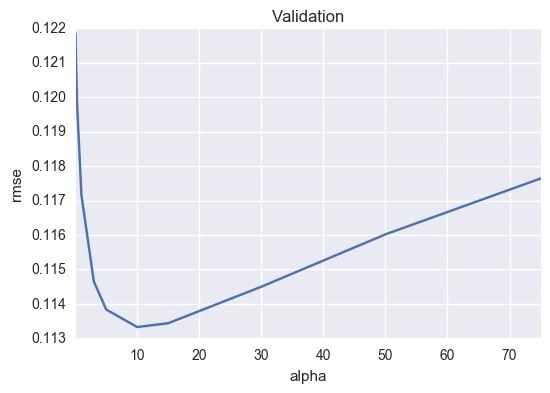

In [84]:

model_ridge = Ridge()

alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation")
plt.xlabel("alpha")
plt.ylabel("rmse")

print cv_ridge.min()

rmse lasso cv 0.109105954315
Lasso picked 111 variables and eliminated the other 156 variables


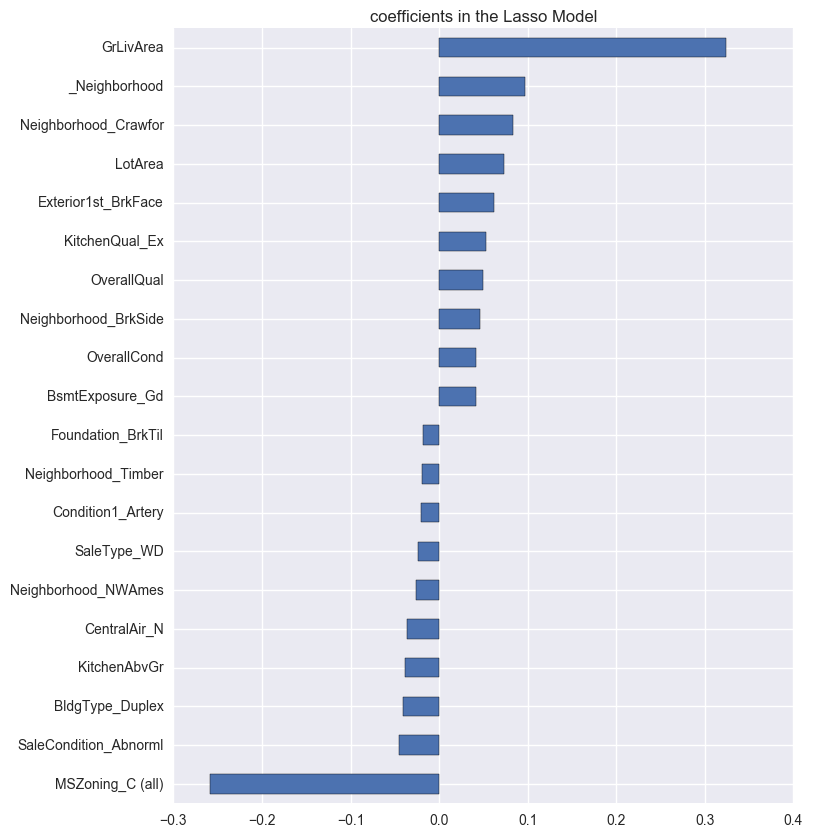

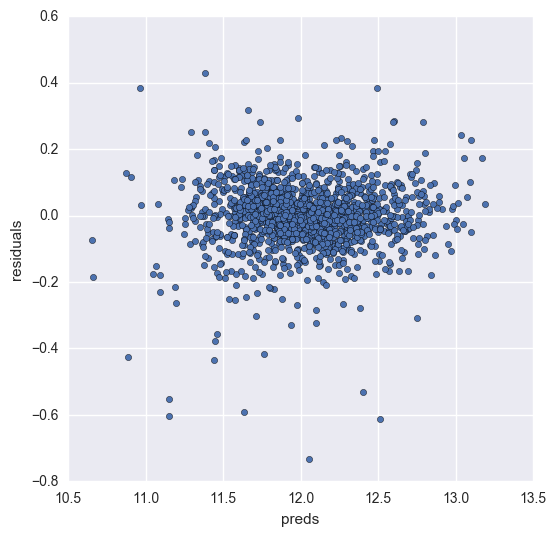

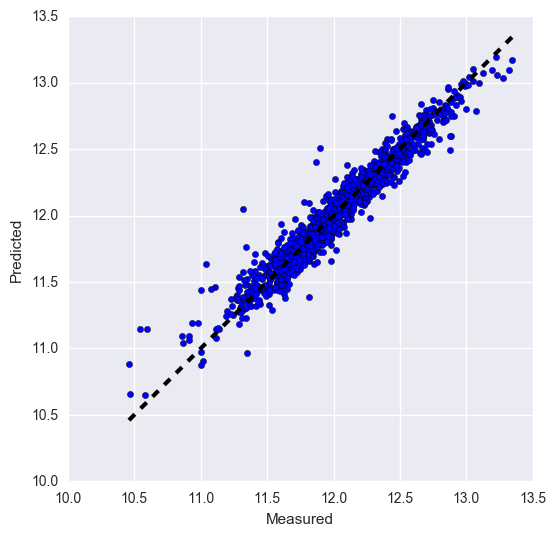

In [90]:
model_lasso = LassoCV(alphas = [1,0.1, 0.001, 0.0005]).fit(X_train, y)

print "rmse lasso cv {}".format(rmse_cv(model_lasso).mean())

coef = pd.Series(model_lasso.coef_, index = X_train.columns)
# print coef

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " + str(sum(coef ==0)) + " variables")

imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])

matplotlib.rcParams["figure.figsize"] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("coefficients in the Lasso Model")

matplotlib.rcParams['figure.figsize'] = (6.0,6.0)

preds = pd.DataFrame({"preds":model_lasso.predict(X_train), "true": y})



preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x= "preds", y = "residuals", kind = "scatter")


# Plotting Cross-Validated Predictions

fig, ax = plt.subplots()
ax.scatter(y, preds.preds)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()



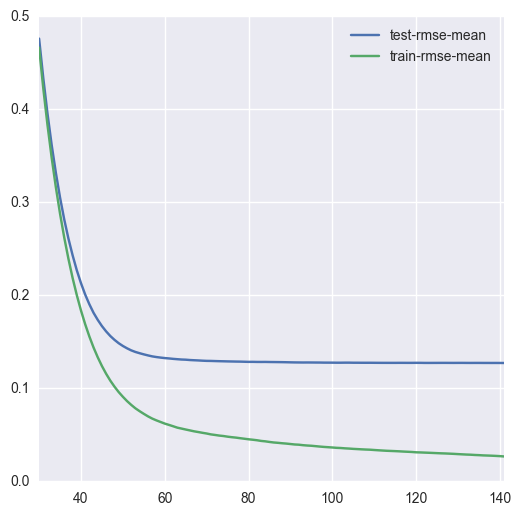

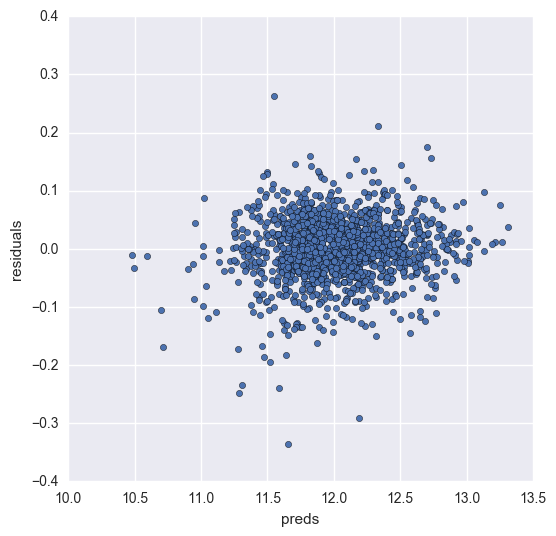

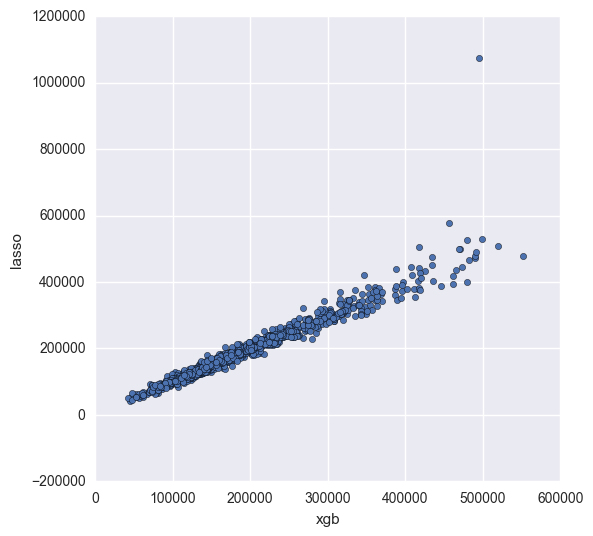

In [11]:
import xgboost as xgb


dtrain = xgb.DMatrix(X_train, label =y)
dtest = xgb.DMatrix(X_test)
params = {"max_delpth":2, "eta":0.1}
model = xgb.cv(params, dtrain, num_boost_round=500, early_stopping_rounds = 100)

model.loc[30:, ["test-rmse-mean","train-rmse-mean"]].plot()


model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth = 3, learning_rate=0.1)
model_xgb.fit(X_train,y)


matplotlib.rcParams['figure.figsize'] = (6.0,6.0)

preds = pd.DataFrame({"preds":model_xgb.predict(X_train), "true": y})



preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x= "preds", y = "residuals", kind = "scatter")


xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x= "xgb", y = "lasso", kind = "scatter")


# train[train["GrLivArea"]>4000].index

# preds = 0.8* lasso_preds  + 0.2 *xgb_preds

# solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
# solution.to_csv("ridge_sol.csv", index= False)

Int64Index([1089], dtype='int64')
      TimeSinceSold  HouseAge  _GarageFinish    _Fence  _Functional  \
1089              3         2            3.0  2.966608          8.0   
1088              3         5            3.0  2.966608          8.0   

      _BsmtFinType2  _BsmtFinType1  _BsmtExposure  _GarageCond  _GarageQual  \
1089       0.693147            6.0       1.609438          3.0          3.0   
1088       0.693147            6.0       0.693147          3.0          3.0   

              ...            SaleType_ConLw  SaleType_New  SaleType_Oth  \
1089          ...                         0             1             0   
1088          ...                         0             0             0   

      SaleType_WD  SaleCondition_Abnorml  SaleCondition_AdjLand  \
1089            0                      0                      0   
1088            1                      0                      0   

      SaleCondition_Alloca  SaleCondition_Family  SaleCondition_Normal  \
1089        

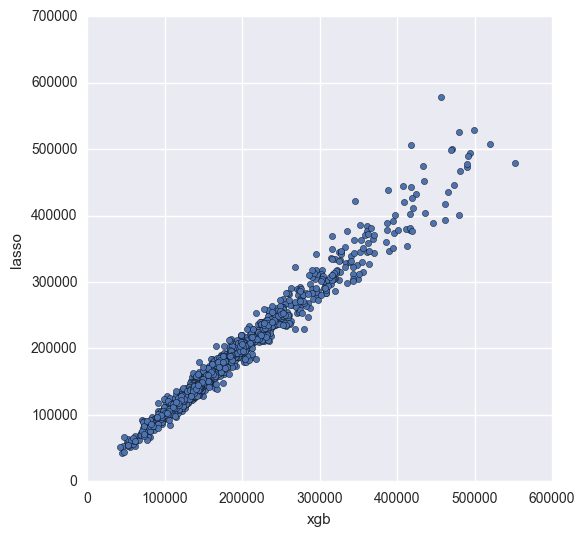

In [12]:
print predictions[predictions['lasso']>800000].index
print X_test.loc[[1089, 1088]]
with pd.option_context('display.max_rows', 999, 'display.max_columns', 10000):
    print X_test.loc[[1089, 1088]]

predictions.set_value(1089,"lasso", predictions.loc[1089]['xgb'])
predictions.plot(x= "xgb", y = "lasso", kind = "scatter")




In [94]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label =y)
dtest = xgb.DMatrix(X_test)
param_test1 = {"n_estimators": [300, 360, 400, 450]}


model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth = 3, learning_rate=0.1)

gsearch1 = GridSearchCV(estimator= model_xgb, param_grid = param_test1, n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y)

print gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_




[mean: 0.90542, std: 0.01034, params: {'n_estimators': 300}, mean: 0.90510, std: 0.00976, params: {'n_estimators': 360}, mean: 0.90516, std: 0.00965, params: {'n_estimators': 400}, mean: 0.90492, std: 0.00947, params: {'n_estimators': 450}] {'n_estimators': 300} 0.905422705615


In [95]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label =y)
dtest = xgb.DMatrix(X_test)
param_test1 = {"max_depth": [2, 5, 7],'min_child_weight': [1,3,5]}


model_xgb = xgb.XGBRegressor(n_estimators=300, max_depth = 3, learning_rate=0.1)

gsearch1 = GridSearchCV(estimator= model_xgb, param_grid = param_test1, n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y)

print gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_




[mean: 0.90911, std: 0.00937, params: {'max_depth': 2, 'min_child_weight': 1}, mean: 0.90954, std: 0.00886, params: {'max_depth': 2, 'min_child_weight': 3}, mean: 0.90953, std: 0.00788, params: {'max_depth': 2, 'min_child_weight': 5}, mean: 0.90214, std: 0.00903, params: {'max_depth': 5, 'min_child_weight': 1}, mean: 0.90889, std: 0.01065, params: {'max_depth': 5, 'min_child_weight': 3}, mean: 0.90652, std: 0.00948, params: {'max_depth': 5, 'min_child_weight': 5}, mean: 0.89976, std: 0.00962, params: {'max_depth': 7, 'min_child_weight': 1}, mean: 0.90636, std: 0.00915, params: {'max_depth': 7, 'min_child_weight': 3}, mean: 0.90478, std: 0.01038, params: {'max_depth': 7, 'min_child_weight': 5}] {'max_depth': 2, 'min_child_weight': 3} 0.909540042961


In [305]:
# tunning max_depth and min_child_weight
param_test1 = {"max_depth": [1, 2, 3],'min_child_weight': [2, 3,4]}

params = {"max_depth":5, "eta":0.1}

model_xgb = xgb.XGBRegressor(n_estimators=300, max_depth = 2, learning_rate=0.1)

gsearch1 = GridSearchCV(estimator= model_xgb, param_grid = param_test1, n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y)

print gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_



[mean: 0.90773, std: 0.00834, params: {'max_depth': 1, 'min_child_weight': 2}, mean: 0.90794, std: 0.00833, params: {'max_depth': 1, 'min_child_weight': 3}, mean: 0.90781, std: 0.00844, params: {'max_depth': 1, 'min_child_weight': 4}, mean: 0.90967, std: 0.00869, params: {'max_depth': 2, 'min_child_weight': 2}, mean: 0.91025, std: 0.00845, params: {'max_depth': 2, 'min_child_weight': 3}, mean: 0.90989, std: 0.00931, params: {'max_depth': 2, 'min_child_weight': 4}, mean: 0.90681, std: 0.00843, params: {'max_depth': 3, 'min_child_weight': 2}, mean: 0.90932, std: 0.00728, params: {'max_depth': 3, 'min_child_weight': 3}, mean: 0.90834, std: 0.00791, params: {'max_depth': 3, 'min_child_weight': 4}] {'max_depth': 2, 'min_child_weight': 3} 0.910251002295


In [96]:
# tunning gamma

params = {"max_depth":3, "eta":0.1}
param_test1 = {"gamma": [i/10.0 for i in range(0,4)]}


model_xgb = xgb.XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=2, min_child_weight=3)

gsearch1 = GridSearchCV(estimator= model_xgb, param_grid = param_test1, n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y)

print gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_




[mean: 0.90954, std: 0.00886, params: {'gamma': 0.0}, mean: 0.90018, std: 0.00835, params: {'gamma': 0.1}, mean: 0.89281, std: 0.00912, params: {'gamma': 0.2}, mean: 0.88738, std: 0.00968, params: {'gamma': 0.3}] {'gamma': 0.0} 0.909540042961


In [97]:
#tunning subsample and colsample_bytree
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

model_xgb = xgb.XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=2, min_child_weight=3, gamma=0.0)

gsearch1 = GridSearchCV(estimator= model_xgb, param_grid = param_test4, n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y)

print gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_



[mean: 0.91476, std: 0.00796, params: {'subsample': 0.6, 'colsample_bytree': 0.6}, mean: 0.91382, std: 0.00924, params: {'subsample': 0.7, 'colsample_bytree': 0.6}, mean: 0.91444, std: 0.00858, params: {'subsample': 0.8, 'colsample_bytree': 0.6}, mean: 0.91429, std: 0.00680, params: {'subsample': 0.9, 'colsample_bytree': 0.6}, mean: 0.91357, std: 0.00738, params: {'subsample': 0.6, 'colsample_bytree': 0.7}, mean: 0.91344, std: 0.00829, params: {'subsample': 0.7, 'colsample_bytree': 0.7}, mean: 0.91337, std: 0.00811, params: {'subsample': 0.8, 'colsample_bytree': 0.7}, mean: 0.91386, std: 0.00729, params: {'subsample': 0.9, 'colsample_bytree': 0.7}, mean: 0.91192, std: 0.00882, params: {'subsample': 0.6, 'colsample_bytree': 0.8}, mean: 0.91343, std: 0.01088, params: {'subsample': 0.7, 'colsample_bytree': 0.8}, mean: 0.91458, std: 0.00965, params: {'subsample': 0.8, 'colsample_bytree': 0.8}, mean: 0.91215, std: 0.01040, params: {'subsample': 0.9, 'colsample_bytree': 0.8}, mean: 0.91364, 

In [309]:
param_test4 = {
 'n_estimators':[360, 370, 375]
}
model_xgb = xgb.XGBRegressor(n_estimators=360, learning_rate=0.1, max_depth=2, min_child_weight=3, gamma=0.0, subsample=0.8, colsample_bytree=0.7)

gsearch1 = GridSearchCV(estimator= model_xgb, param_grid = param_test4, n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y)

print gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_



[mean: 0.91491, std: 0.00830, params: {'n_estimators': 360}, mean: 0.91490, std: 0.00822, params: {'n_estimators': 370}, mean: 0.91473, std: 0.00830, params: {'n_estimators': 375}] {'n_estimators': 360} 0.914908347854


In [310]:
param_test4 = {
 'learning_rate':[i/10.0 for i in range(1,4)]
}
model_xgb = xgb.XGBRegressor(n_estimators=360, learning_rate=0.1, max_depth=2, min_child_weight=3, gamma=0.0, subsample=0.8, colsample_bytree=0.7)

gsearch1 = GridSearchCV(estimator= model_xgb, param_grid = param_test4, n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y)

print gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_




[mean: 0.91491, std: 0.00830, params: {'learning_rate': 0.1}, mean: 0.90536, std: 0.00926, params: {'learning_rate': 0.2}, mean: 0.89773, std: 0.00999, params: {'learning_rate': 0.3}] {'learning_rate': 0.1} 0.914908347854


In [2]:
params = {"max_delpth":3, "eta":0.1, "min_child_weight":2, "gamma": 0.0, "learning_rate":0.1,'subsample': 0.8, 'colsample_bytree': 0.6}
model = xgb.cv(params, dtrain, num_boost_round=500, early_stopping_rounds = 100)

model.loc[30:, ["test-rmse-mean","train-rmse-mean"]].plot()


model_xgb = xgb.XGBRegressor(n_estimators=360, learning_rate=0.1, max_depth=3, min_child_weight=2, gamma=0.0, subsample=0.8, colsample_bytree=0.6)
model_xgb.fit(X_train,y)


matplotlib.rcParams['figure.figsize'] = (6.0,6.0)

preds = pd.DataFrame({"preds":model_xgb.predict(X_train), "true": y})

preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x= "preds", y = "residuals", kind = "scatter")


xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

predictions = pd.DataFrame({"xgb":xgb_preds, "lasso":lasso_preds})
predictions.plot(x= "xgb", y = "lasso", kind = "scatter")


# Plotting Cross-Validated Predictions

fig, ax = plt.subplots()
ax.scatter(y, preds.preds)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()




NameError: name 'xgb' is not defined

0.136335182251


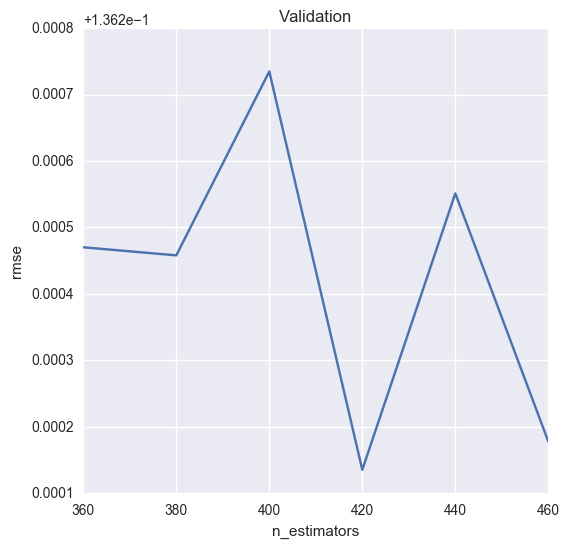

In [91]:
# try Random forest





# from treeinterpreter import treeinterpreter as ti

                           
# rf = RandomForestRegressor(n_estimators=50, max_depth=40)
# print rmse_cv(rf).mean()                           

# n_estimators = [50, 160, 180, 200, 220, 240, 500]
n_estimators = [ 360, 380, 400, 420, 440, 460]
cv_rf = [rmse_cv(RandomForestRegressor(n_estimators = n_estimator, n_jobs=-1)).mean() for n_estimator in n_estimators]
cv_rf = pd.Series(cv_rf, index = n_estimators)
cv_rf.plot(title = "Validation")
plt.xlabel("n_estimators")
plt.ylabel("rmse")

print cv_rf.min()




# preds = 0.6* lasso_preds  + 0.3 *xgb_preds + 0.1 * rf_preds

# solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
# solution.to_csv("ridge_sol.csv", index= False)

0.133186018355


NameError: name 'lasso_preds' is not defined

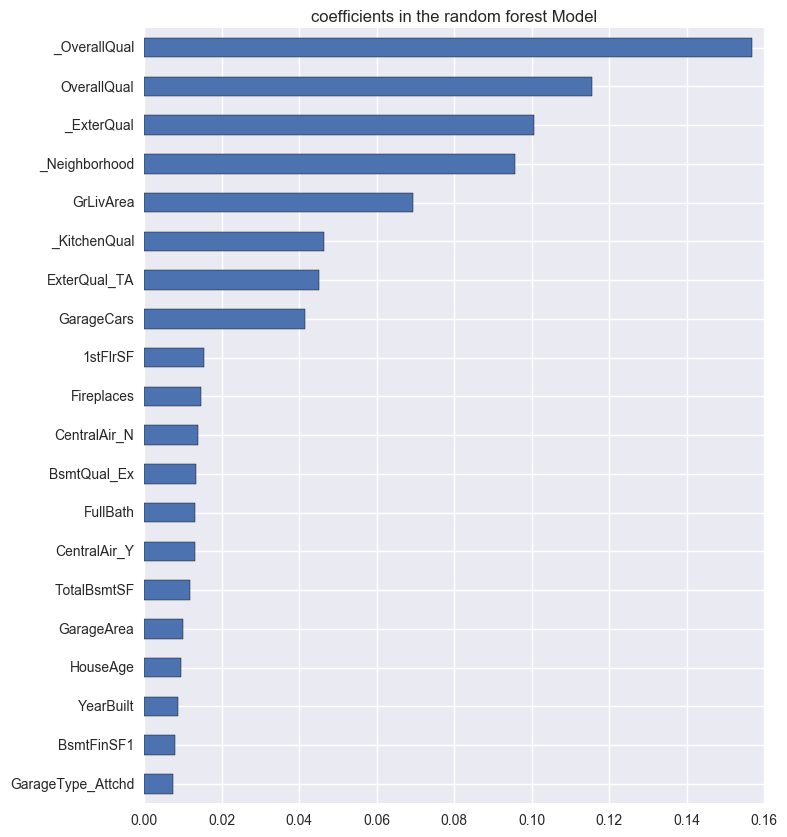

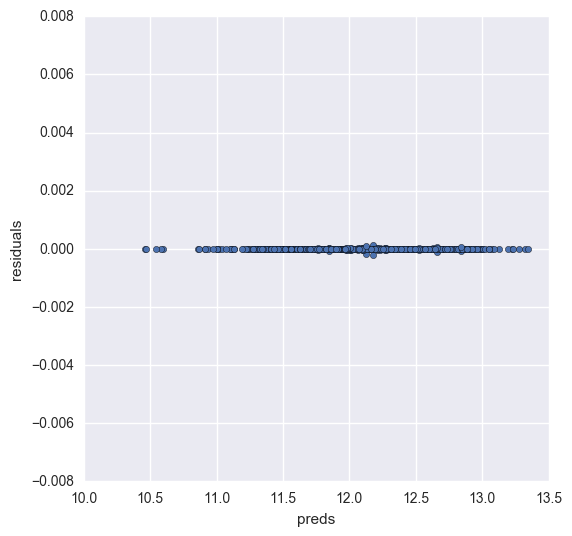

In [4]:
# from treeinterpreter import treeinterpreter as ti
n_estimators = [50, 160, 180, 200, 220, 240]
# cv_et = [rmse_cv(ExtraTreesRegressor(n_estimators = n_estimator, max_depth=60, n_jobs=-1)).mean() for n_estimator in n_estimators]
# cv_et = pd.Series(cv_et, index = n_estimators)
# cv_et.plot(title = "Validation")
# plt.xlabel("n_estimators")
# plt.ylabel("rmse")

# print cv_et.min()

ef = ExtraTreesRegressor(n_estimators=400)

ef.fit(X_train, y)

coef = pd.Series(ef.feature_importances_, index = X_train.columns)

imp_coef = coef.sort_values().tail(20)

matplotlib.rcParams["figure.figsize"] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("coefficients in the random forest Model")

print rmse_cv(ef).mean()
matplotlib.rcParams['figure.figsize'] = (6.0,6.0)
prediction = ef.predict(X_train)
preds = pd.DataFrame({"preds": prediction, "true": y})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x= "preds", y = "residuals", kind = "scatter")
ef_preds = np.expm1(ef.predict(X_test))
predictions = pd.DataFrame({"ef":ef_preds, "lasso":lasso_preds})
predictions.plot(x= "ef", y = "lasso", kind = "scatter")



# preds = 0.9* lasso_preds  + 0.1 *xgb_preds + 0 * ef_preds

# solution = pd.DataFrame({"id":test.Id, "SalePrice":preds})
# solution.to_csv("merge.csv", index= False)


In [311]:



param_test4 = {
 'n_estimators':[380, 390, 400],
 'max_depth':[60, 70, 80]
}

ef = ExtraTreesRegressor(n_estimators=400)


gsearch1 = GridSearchCV(estimator= ef, param_grid = param_test4, n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y)

print gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

[mean: 0.88667, std: 0.01434, params: {'n_estimators': 380, 'max_depth': 60}, mean: 0.88636, std: 0.01335, params: {'n_estimators': 390, 'max_depth': 60}, mean: 0.88663, std: 0.01401, params: {'n_estimators': 400, 'max_depth': 60}, mean: 0.88556, std: 0.01352, params: {'n_estimators': 380, 'max_depth': 70}, mean: 0.88589, std: 0.01432, params: {'n_estimators': 390, 'max_depth': 70}, mean: 0.88599, std: 0.01422, params: {'n_estimators': 400, 'max_depth': 70}, mean: 0.88652, std: 0.01470, params: {'n_estimators': 380, 'max_depth': 80}, mean: 0.88609, std: 0.01434, params: {'n_estimators': 390, 'max_depth': 80}, mean: 0.88605, std: 0.01343, params: {'n_estimators': 400, 'max_depth': 80}] {'n_estimators': 380, 'max_depth': 60} 0.886673211375


In [6]:



param_test4 = {
 'n_estimators':[400, 420, 440],
 'max_depth':[40, 50, 60]
}

rf = RandomForestRegressor(n_estimators=400)

gsearch1 = GridSearchCV(estimator= rf, param_grid = param_test4, n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_train,y)

print gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

[mean: 0.88086, std: 0.01124, params: {'n_estimators': 400, 'max_depth': 40}, mean: 0.87972, std: 0.01189, params: {'n_estimators': 420, 'max_depth': 40}, mean: 0.87994, std: 0.01236, params: {'n_estimators': 440, 'max_depth': 40}, mean: 0.88056, std: 0.01138, params: {'n_estimators': 400, 'max_depth': 50}, mean: 0.88050, std: 0.01047, params: {'n_estimators': 420, 'max_depth': 50}, mean: 0.88050, std: 0.01159, params: {'n_estimators': 440, 'max_depth': 50}, mean: 0.88025, std: 0.01192, params: {'n_estimators': 400, 'max_depth': 60}, mean: 0.88055, std: 0.01133, params: {'n_estimators': 420, 'max_depth': 60}, mean: 0.87979, std: 0.01204, params: {'n_estimators': 440, 'max_depth': 60}] {'n_estimators': 400, 'max_depth': 40} 0.88086467156


In [39]:
# param_test4 = {
#  'alpha':[0.001,0.0001,0.01,0.1],
# }

rf = Lasso(alpha=0.001,max_iter=50000)


# gsearch1 = GridSearchCV(estimator= rf, param_grid = param_test4, n_jobs=4,iid=False, cv=5)
# gsearch1.fit(X_train,y)

# print gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

# rf = LassoCV(alphas=[1,0.1,0.001,0.0005,5e-4])
rf.fit(X_train, y)
print "rmse lasso cv {}".format(rmse_cv(rf,10).mean())

rf = LassoCV(alphas=[1,0.1,0.001,0.0005,5e-4],cv=10)
rf.fit(X_train, y)
print "rmse lasso cv {}".format(rmse_cv(rf,10).mean())



    

KeyboardInterrupt: 

/Users/shawn/Documents/workspace/kaggle/Facial-Keypoints-Detection/ENV/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:479: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


rmse elastic cv 0.107787479023
rmse elastic cv 0.109385493632
Elastic picked 113 variables and eliminated the other 194 variables


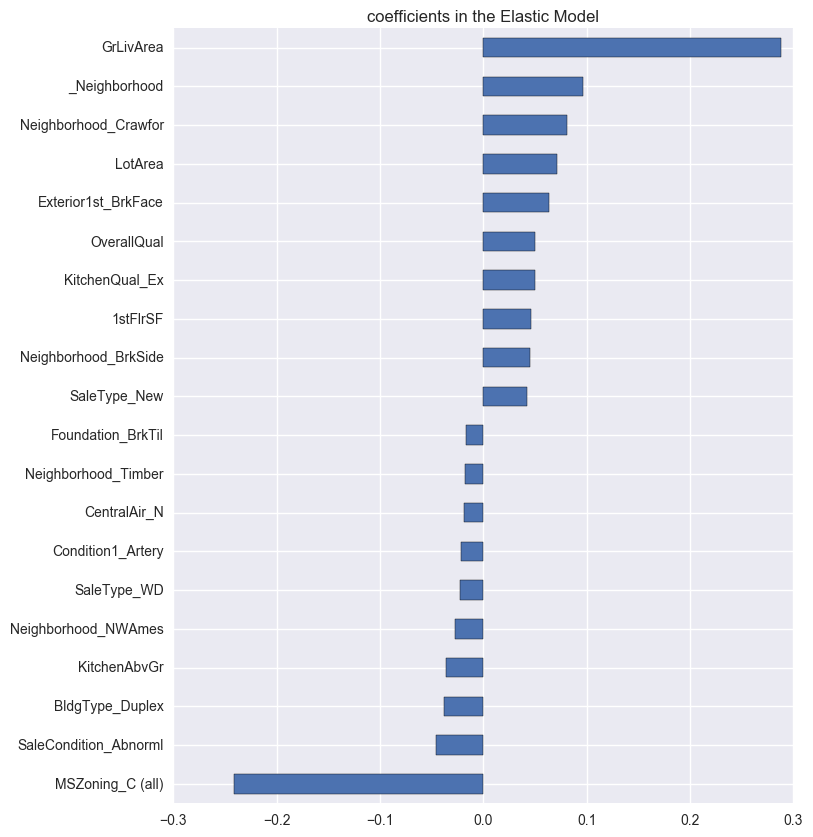

In [3]:
enet = ElasticNetCV(alphas=[1,0.1,0.001,0.0005,5e-4], l1_ratio=0.5, max_iter=50000)
enet.fit(X_train, y)
print "rmse elastic cv {}".format(rmse_cv(enet,10).mean())

enet = ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=50000)
enet.fit(X_train, y)
print "rmse elastic cv {}".format(rmse_cv(enet).mean())


coef = pd.Series(enet.coef_, index = X_train.columns)
# print coef

print("Elastic picked " + str(sum(coef != 0)) + " variables and eliminated the other " + str(sum(coef ==0)) + " variables")

imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])

matplotlib.rcParams["figure.figsize"] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("coefficients in the Elastic Model")




In [5]:
rf = RandomForestRegressor(n_estimators=1000,max_depth=4)
rf.fit(X_train, y)
print "rmse random forest cv {}".format(rmse_cv(rf,cv=5).mean())


rmse random forest cv 0.169187842462


In [33]:
from sklearn.linear_model import BayesianRidge

bayes = BayesianRidge()
bayes.fit(X_train, y)
print "rmse bayes cv {}".format(rmse_cv(bayes,10).mean())



rmse bayes cv 0.109884423314
